
\begin{equation*} \textrm{Linear dynamics with Gaussian noise }  
x_{t}=Ax_{t-1}+Bu_{t-1}+w_{t}  \,\,where\,  w_{t} \sim \mathcal{N}(0,Q)\end{equation*}\\

\begin{equation*} \textrm{Linear measurement model with Gaussian noise }  
z_{t}=Hx_{t}+n_{t} \,\,where\,  n_{t} \sim \mathcal{N}(0,R)\end{equation*}\\


In [211]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import random

In [212]:
number_steps = 10
ground_truth_x = np.linspace(0,10,number_steps+1)
ground_truth_y = ground_truth_x.copy()
ground_truth = np.stack((ground_truth_x,ground_truth_y),axis=1)

x0 = 0 
y0 = 0

xt = [np.array([x0, y0])] # motion state
ut = np.array([1, 1]) # initial input

# Model of our system
A = np.identity(2)

# System reaction to input
B = np.identity(2)

# process process noise covariance
Q = np.array([[0.05, 0.00001],[0.00001, 0.05]])

#measurements
zt = []

# Model of measurement
H = np.identity(2)

# How noise might change after each time step
R = np.array([[0.05, 0.0001],[0.0001, 0.05]])


In [213]:
for i in range(number_steps):
    motion_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=Q)
    xt_next = A @ xt[-1] + B @ ut + motion_noise
    xt.append(xt_next)

    measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R)
    zt_next = H @ ground_truth[i+1] + measurement_noise
    zt.append(zt_next)

11


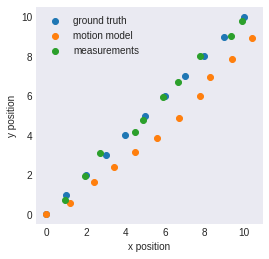

In [217]:

xt = np.array(xt)
zt = np.array(zt)
plt.scatter(ground_truth[:,0], ground_truth[:,1])
plt.scatter(xt[:,0], xt[:,1])
plt.scatter(zt[:,0], zt[:,1])
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['ground truth', 'motion model', 'measurements'])
plt.gca().set_aspect('equal', adjustable='box')


\begin{equation*} \textrm{Prediction Step}  
\end{equation*}\\

\begin{equation*} 
\hat{x}_{t}=A\hat{x}_{t-1}+Bu_{t-1} \end{equation*}\\

\begin{equation*} 
\hat{\Sigma}_{t}=A\hat{\Sigma}_{t-1}A^T+Q \end{equation*}



In [5]:
def predict(A, B, Q, ut, x_hat, sigma_hat):
    x_hat  =  A @ x_hat + B @ ut
    sigma_hat = A @ sigma_hat @ A.T + Q
    return (x_hat, sigma_hat)


\begin{equation*} \textrm{Update Step}  
\end{equation*}\\

\begin{equation*} 
\delta_{\hat{x_{t}} =z_{t}-H\hat{x_{t}}  \\





In [6]:
def update(H, R, z, x_hat, sigma_hat):
    residual_x_hat = z - H @ x_hat

    residual_sigma_hat = H @ sigma_hat @ H.T + R
    kalman_gain = sigma_hat @ H.T @ np.linalg.inv(residual_sigma_hat)

    x = x_hat + kalman_gain @ residual_x_hat
    sigma =  (np.eye(2) - kalman_gain @ H) @ sigma_hat

    return x, sigma

In [216]:
xt = [np.array([x0, y0])] # motion state

x_hat = np.array([1,1])
sigma_hat = np.array([[0.3, 0], [0, 0.3]])

measured_states = []
filtered_states = []

history = [{'mu': x_hat, 'sigma': sigma_hat}]

for i in range(number_steps):

    motion_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=Q)
    xt_next = A @ xt[-1] + B @ ut + motion_noise
    xt.append(xt_next)
    
    x_hat, sigma_hat = predict(A, B, Q, ut, x_hat, sigma_hat)
    
    measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R)
    
    zt_next = H @ ground_truth[i+1] + measurement_noise
    
    x_hat, sigma_hat = update(H,R, zt_next, x_hat, sigma_hat)
    
    history.append({'mu': x_hat, 'sigma': sigma_hat})

    measured_states.append(zt_next)
    
    filtered_states.append(x_hat)

measured_states = np.array(measured_states)
filtered_states = np.array(filtered_states)
xt = np.array(xt)

In [209]:
def plot_multivariate_gaussian(ax, mu, sigma):
    x = np.linspace(-1,10,100)
    y = np.linspace(-1,10,100)
    X, Y = np.meshgrid(x,y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    rv = multivariate_normal(mean=mu, cov=sigma)
    Z = rv.pdf(pos)
    surface = ax.plot_surface(X, Y, Z, alpha=0.8, cmap=plt.cm.jet, antialiased=True)
    cset = ax.contourf(X, Y, Z, zdir='x', offset=-1, cmap=plt.cm.jet)
    cset = ax.contourf(X, Y, Z, zdir='y', offset=10, cmap=plt.cm.jet)
    ax.set_zlim(0, 1)
    ax.set_zticks(np.linspace(0,1,5))


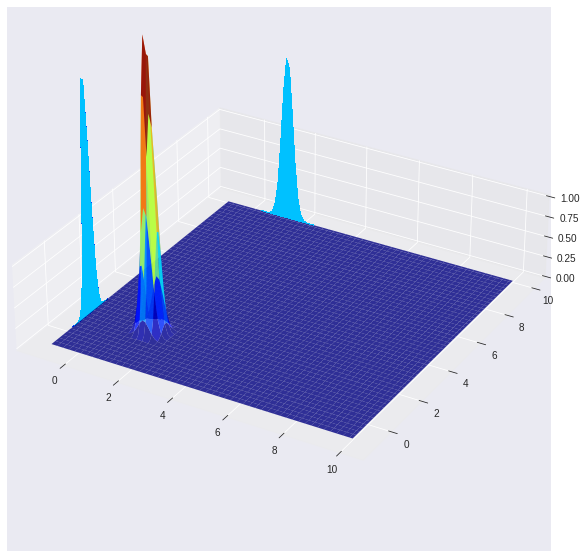

In [210]:
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect((1, 1, 0.25))
plot_multivariate_gaussian(ax, history[1]['mu'], history[1]['sigma'])
plt.show()

10


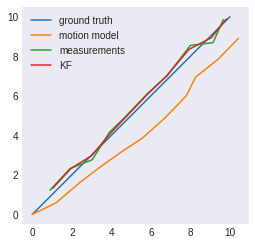

In [218]:
plt.plot(ground_truth[:,0], ground_truth[:,1])
plt.plot(xt[:,0], xt[:,1])
plt.plot(measured_states[:,0], measured_states[:,1])
plt.plot(filtered_states[:,0], filtered_states[:,1])
print(len(filtered_states))
plt.legend(['ground truth', 'motion model', 'measurements', 'KF'])
plt.gca().set_aspect('equal', adjustable='box')